In [1]:
import numpy as np
import scipy.stats as ss
import ipywidgets as wd
import yaml
import time
import os
import matplotlib.pyplot as plt

In [2]:
import sys
import logging

# Take care of some logging
# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(filename='example.log',level=logging.INFO, filemode='w', format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
logging.getLogger().addHandler(logging.StreamHandler(sys.stderr))

## Test logger functionality: 
# logging.warning('This is a warning message this should be printed on your console, its level is above the set level')
# logging.info('This is an info message it should be printed now!')
# logging.debug('This is a debug message which will not be shown, its level is below the set level')

In [3]:
sleeptime = 1  # delay (seconds) between messages.

In [4]:
def beta_dist(min_value=0, max_value=1, a=1, b=1):
    return ss.beta(loc=min_value, scale=(max_value-min_value), a=a, b=b)

def auto_fill(height='auto', width='auto', label=''):
    return wd.Button(description=label, layout=auto_lay(width,height))

def auto_lay(width='auto', height='auto'):
    return wd.Layout(height=height, width=width)

In [75]:
def generate_sample_dict(S:dict):
    P = S.dist # take a sample set that has input samples already generated.
    lam = S.samples
    V = {n:{v: None for v in P.vars} for n in P.names}
    for d in range(S.dim):
        p_info = P.params[d].rsplit('-')
        V[p_info[1]][p_info[0]] = lam[:,d]
    return V

def generate_samples_from_dict(D:dict, num_samples:int=1) -> np.array:
    r"""
     This module takes a nested dictionary (one inside another) 
     which contains the description of the distribution in the parameters,
     and generates the samples described therein.
    """
    samples = {}
    for outer_key in D.keys():
        for inner_key in D[outer_key].keys():
            variable_name = "%s-%s"%(str(outer_key).replace(' ', '_'),
                                     str(inner_key).replace(' ', '_'))
            
            distribution_params = D[outer_key][inner_key]
            distribution = ss.beta(**distribution_params)
            
            random_samples = distribution.rvs(int(num_samples))
            
            samples[variable_name] = {}
            samples[variable_name] = random_samples
            
    return samples

def sum_it_all(D:dict):
    r"""
    The first element in the keys of D (split by "-") is taken to be the
    frequency with which an event occurs. It will be parsed as a float.
    """
    num_samples = len(D[list(D.keys())[0]])
    # I think this may end up faster than vectorizing for large n...
    # don't have to keep multi-dim array in memory, just a (nx1)-dimensional one.
    cum_sum = np.zeros((num_samples,1))
    for outer_key in D.keys():
        frequency = float(outer_key.split('-')[0])
        samples = D[outer_key].reshape(-1,1)
        cum_sum += samples*frequency
    return cum_sum

def db_to_pushforward(DB:dict, num_samples:int=10):
    S = generate_samples_from_dict(DB, num_samples)
    summed_samples = sum_it_all(S)
    mn, mx = summed_samples.min(), summed_samples.max()
    x = np.linspace(mn, mx, 1000)
    kde = ss.gaussian_kde(summed_samples.reshape(1,-1))
    y = kde.pdf(x)
    arr = np.array([item[1] for item in S.items()]).T  # numpy array of samples
    return (x, y, summed_samples, kde, arr)


In [32]:
def mid_preset(min_val, max_val, confidence):
    """
    Returns beta distribution parameters (symmetric)
    """
    loc = min_val
    scale = max_val - min_val
    a = b = np.maximum(np.minimum(confidence+1,3),0.1)**2
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

def high_preset(min_val, max_val, confidence):
    """
    Returns beta distribution parameters (left skewed)
    """
    loc = min_val
    scale = max_val - min_val
    b = np.minimum(2.5,confidence+1.5)
    b = np.maximum(b,0.1)
    a = 6 - b 
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

def low_preset(min_val, max_val, confidence):
    """
    Returns beta distribution parameters (right skewed)
    """
    loc = min_val
    scale = max_val - min_val
    a = np.minimum(confidence+1.5,2.5)
    a = np.maximum(a,0.1)
    b = 6 - a 
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

In [7]:
def make_preset_grid():
    """
    Return grid layout (1x2) with three buttons and a slider,
    for preset definitions.
    """
    presets = wd.GridspecLayout(2,1)
#     btn_left = wd.Button(description='left', layout=auto_lay())
#     btn_cent= wd.Button(description='center', layout=auto_lay())
#     btn_right = wd.Button(description='right', layout=auto_lay())
#     presets[0,0] = btn_left
#     presets[0,1] = btn_cent
#     presets[0,2] = btn_right
    
    opt_slide = wd.FloatSlider(description='normalcy', value=0, min=0,max=1,step=0.1,
                               layout=auto_lay('100%', 'auto'),
                               continuous_update=False)
    options = wd.Dropdown(description="Uncertainty",
                          options=['centered', 'left-leaning', 'right-leaning'],
                          layout=auto_lay('100%', 'auto'))
    
    presets[1,0] = opt_slide
    presets[0,0] = options
    logging.info("Preset grid created.")
#     return presets, [btn_left, btn_cent, btn_right], opt_slide
    return presets, options, opt_slide

In [8]:
freq_list = [1,2,4,6,12,24,26,52,365]
def make_db_setter(DB):
    param_setter = wd.GridspecLayout(2,3)#, layout=auto_lay())
    freq_dropdown = wd.Dropdown(value=1, options=freq_list, description='Frequency', layout=auto_lay('30%') )
    param_list = list(DB[freq_dropdown.value].keys())
    logging.info("Loaded keys from database key #%s."%freq_dropdown.value)
    param_dropdown = wd.Dropdown(options=param_list, description='Item',layout=auto_lay('70%'))
    
    param_text = wd.Text(description = 'Description', layout=wd.Layout(height='auto', width='100%'))
    param_setter[1,0:2] = param_text

    add_button = wd.Button(description='add', layout=wd.Layout(height='100%', width='100%'))
    rem_button  = wd.Button(description='remove', layout=wd.Layout(height='100%', width='100%'))

    param_setter[1,2] = wd.HBox([rem_button, add_button])
    info = wd.Label(layout=auto_lay())
    
    param_setter[0,1:3] = wd.HBox([param_dropdown, freq_dropdown])
    param_setter[0,0] = info
    info.value = "Enter cost and how often it occurs:"
    logging.info("Initialized database-setting GUI.")
    return param_setter, [info, param_dropdown, param_text, add_button, rem_button, freq_dropdown]

In [9]:
beta_setter = wd.GridspecLayout(2,2, layout=auto_lay())
min_txt = wd.FloatText(value=0, description="MIN ($)", layout=auto_lay())
max_txt = wd.FloatText(value=1, description="MAX ($)", layout=auto_lay())
beta_setter[0,0] = min_txt
beta_setter[0,1] = max_txt
a = wd.FloatSlider(value=1, min=0, max=10, description='a', layout=auto_lay(), disabled=False)
b = wd.FloatSlider(value=1, min=0, max=10, description='b', layout=auto_lay(), disabled=False)

beta_setter[1,0] = wd.Label("Enter min/max values for item.", layout=auto_lay()) 
beta_setter[1,1] = wd.Label("Play with slider until plot reflects preferences.", layout=auto_lay())

# beta_setter[2,0] = a 
# beta_setter[2,1] = b


In [10]:
# Initiate (Empty) Database or Load Existing One.
db_name = 'db.yaml'
if not os.path.exists(db_name):
    logging.info('No database found. Initializing.')
    with open(db_name, 'w') as db:
        DB = {freq: {} for freq in freq_list}  # populate outer-level keys with frequencies
        yaml.dump(DB, db)
else:
    logging.info("Database found, loaded.")
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)

Database found, loaded.


In [11]:
param_setter, widgets = make_db_setter(DB)
info, param_dropdown, param_text, add_button, rem_button, freq_dropdown = widgets

presets, options, opt_slide = make_preset_grid()
# btn_left, btn_cent, btn_right = buttons

Loaded keys from database key #1.
Initialized database-setting GUI.
Preset grid created.


In [12]:
def get_states(*args):
    """
    Read states from sliders.
    """
    if min_txt.value > max_txt.value:
        info.value = "Min > Max. Switching..."
        time.sleep(sleeptime)
        info.value = ""
        mn, mx = np.copy(max_txt.value), np.copy(min_txt.value)
        max_txt.value = mx
        min_txt.value = mn
    vals = [min_txt.value, max_txt.value]
    return {'loc': vals[0], 'scale': vals[1] - vals[0], 'a': a.value, 'b': b.value}

def update_state(state):
    """
    Set states on sliders.
    """
    max_txt.value = state['loc'] + state['scale']
    min_txt.value = state['loc']
    a.value = state['a']
    b.value = state['b']

def add_key(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    freq = freq_dropdown.value
    key_list = DB[freq].keys() # grab keys from back-end
    
    txt = param_text.value.replace(' ', '_')
    if len(txt) > 0:
        states = get_states(args)
        
        # if adding a new entry, copy over existing info.
        if txt not in key_list: 
            state_of_operation = "added"
        else:  # overwriting
            state_of_operation = "overwritten"

        DB[freq][txt] = get_states(args)
        info.value = txt + " : " + " has been %s."%state_of_operation
        time.sleep(sleeptime)
#         info.value = " "
#         # clean up list
#         if 'default' in key_list:
#             DB[freq].pop('default')
        with open(db_name, 'w') as db:
            yaml.dump(DB, db)
        param_dropdown.options = list(DB[freq].keys())
        param_dropdown.value = txt
    else:
        info.value = "Nothing was entered."


def lookup_key(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    try:
        existing_keys = DB[freq_dropdown.value].keys()
        logging.info('keys of length %d'%len(existing_keys))
        if len(existing_keys) == 0:
            info.value = "Category contains no entries."
            param_dropdown.options = existing_keys
            param_dropdown.value = ""
        else:  # if there is data, overwrite the options
            param_dropdown.options = existing_keys

            state = DB[freq_dropdown.value][param_dropdown.value]
            # TODO: Set states
    #         param_text.value = param_dropdown.value
            param_text.value = "" # clear
            max_txt.value = state['loc'] + state['scale']
            min_txt.value = state['loc']
            a.value = state['a']
            b.value = state['b']
            info.value = "Loaded database state."
    except KeyError:
        info.value = "No matching entry."
        logging.debug("No matching entry encountered. This should be an unreachable state.")
    except:  # attempting to set empty string
        pass
    time.sleep(sleeptime)
    info.value = ""


def remove_var(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    freq = freq_dropdown.value
    txt = param_text.value.replace(' ', '_')
    if len(txt) > 0:
        if txt in list(DB[freq].keys()): # if key exists, remove it
            info.value = "%s was removed."%param_dropdown.value
            DB[freq].pop(txt)
            with open(db_name, 'w') as db:
                    yaml.dump(DB, db)
            time.sleep(sleeptime)
            param_dropdown.options = list(DB[freq].keys())
        else:  # otherwise raise error
            info.value = "Entry not in database."
            time.sleep(sleeptime)
#         info.value = ""
        # update dropdown
        if len(param_dropdown.value) == 0:  # empty entry
            pass
        else:
            param_text.value = param_dropdown.value
    else:
        info.value = "Please enter some text."
        time.sleep(sleeptime)
#         info.value = ""
        
        
def preset_btn_left(*args):
    state = low_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)
    
def preset_btn_cent(*args):
    state = mid_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)
    
def preset_btn_right(*args):
    state = high_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)

# btn_left.on_click(preset_btn_left)
# btn_cent.on_click(preset_btn_cent)
# btn_right.on_click(preset_btn_right)

param_dropdown.observe(lookup_key, 'value')
freq_dropdown.observe(lookup_key, 'value')
rem_button.on_click(remove_var)
add_button.on_click(add_key)
# lookup_key()

In [13]:
# head = wd.Label("Potential Value",layout=auto_lay())
# foot = wd.IntSlider(layout=auto_lay())
# left = None
# cent = auto_fill()
# right = None

In [14]:
# APP = wd.AppLayout(header=None, 
#              footer=None,
#              left_sidebar=param_setter,
#              right_sidebar=beta_setter,
#              center=None)

In [15]:
# display(APP)

In [60]:
out_kde = wd.Output(layout=auto_lay('100%', '100%'))
out_prev = wd.Output(layout=auto_lay('100%', '100%'))

plt.rcParams['figure.figsize'] = 7,4

def get_observed():
    dist = ss.beta(a=1,b=1,loc=desired.value[0], scale=desired.value[1] - desired.value[0])
    return dist

@out_kde.capture(clear_output=True, wait=True)
def mykde():
    fig, ax = plt.subplots(nrows=1, ncols=1);
    x, y, summed_samples, kde, arr = db_to_pushforward(DB, samples.value)
    desired.max = x[-1]
    desired.min = x[0]
    ax.vlines(desired.value[0], 0, y.max())
    ax.vlines(desired.value[1], 0, y.max())

    line, = ax.plot(x, y)
    ax.set_xlabel('Total Cost')
    ax.set_ylabel('Likelihood')
    #     line.set_ydata(y)
    #     line.set_xdata(x)
    #     ax.relim()
    #     ax.autoscale()

    obs_dist = get_observed()
    ratio = obs_dist.pdf(summed_samples).ravel()/kde.pdf(summed_samples.T).ravel()
    n = len(summed_samples)
    r = np.random.rand(n)
    R = ratio/ratio.max()
    acc_inds = R > r
    ax.scatter(summed_samples[acc_inds], np.zeros(sum(acc_inds)))
    acc_samps = arr[acc_inds,:]


In [17]:
@out_prev.capture(clear_output=True, wait=True)
def myprev():
    fig, ax = plt.subplots(nrows=1, ncols=1);
    x = np.linspace(min_txt.value, max_txt.value, 1000)
    if x.max() - x.min() == 0:
        ax.vlines(x.min(), 0, 1)
    else:
        y = beta_dist(min_txt.value, max_txt.value, a.value, b.value).pdf(x)
        line, = ax.plot(x, y)
    ax.set_xlabel('Individual Cost')
    ax.set_ylabel('Likelihood')
    ax.set_title('%s-%s'%(freq_dropdown.value, param_dropdown.value))
#     line.set_ydata(y)
#     line.set_xdata(x)
#     ax.relim()
#     ax.autoscale()
    plt.show()


In [18]:
def kde_prev(val):
    mykde()
    return None

def beta_prev(val):
    if options.value == "left-leaning":
        preset_btn_left()
    elif options.value == "right-leaning":
        preset_btn_right()
    else:
        preset_btn_cent()
    
    myprev()
    return None

In [19]:
options.observe(beta_prev, 'value')
opt_slide.observe(beta_prev, 'value')

In [20]:
G = wd.GridspecLayout(6,3)
G[0,:] = param_setter
# G[1,0] = auto_fill(height='10%')
G[1,:] = beta_setter
# G[0:2,:] = auto_fill(label="SETTINGS")
G[2,0] = presets
G[2:4,1:] = wd.HBox([auto_fill(width='10%'), out_prev])
# beta_prev()

# G[4:9,0] = auto_fill(label='PLOT')
# G[4:9,1] = auto_fill(label='PLOT')
# G[7,:] = beta_setter
# G[8,:] = param_setter
# G[9:10,0:] = auto_fill(label='RUN')
# G[,2] = wd.Button(layout=wd.Layout(height='auto', width='50%'))
# G[:,2] = wd.Button(layout=auto_lay())

In [21]:
display(G)

GridspecLayout(children=(GridspecLayout(children=(Text(value='', description='Description', layout=Layout(grid…

In [22]:
with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
# DB

In [57]:
H = wd.GridspecLayout(2,3)
H[2:,1] = out_kde
desired = wd.FloatRangeSlider(continuous_update=False)
samples = wd.IntSlider(description="Size", value=100, min=100, max=10000, continuous_update=False)
H[0:1,0] = samples
H[0:1,1] = desired
btn = wd.Button(description="Preview")
H[0:1,2] = btn

# samples.observe(kde_prev, 'value')
# desired.observe(kde_prev, 'value'
btn.on_click(kde_prev)

In [58]:
display(H)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001', height='100%', width='100%'), outputs=({'…

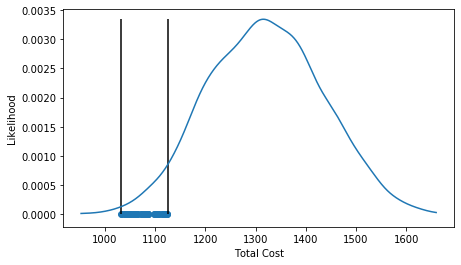

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1);
x, y, summed_samples, kde, arr = db_to_pushforward(DB, samples.value)
desired.max = x[-1]
desired.min = x[0]
ax.vlines(desired.value[0], 0, y.max())
ax.vlines(desired.value[1], 0, y.max())

line, = ax.plot(x, y)
ax.set_xlabel('Total Cost')
ax.set_ylabel('Likelihood')
#     line.set_ydata(y)
#     line.set_xdata(x)
#     ax.relim()
#     ax.autoscale()

obs_dist = get_observed()
ratio = obs_dist.pdf(summed_samples).ravel()/kde.pdf(summed_samples.T).ravel()
n = len(summed_samples)
r = np.random.rand(n)
R = ratio/ratio.max()
acc_inds = R > r
ax.scatter(summed_samples[acc_inds], np.zeros(sum(acc_inds)))
acc_samps = arr[acc_inds,:]

In [82]:
acc_samps.shape

(39, 7)

In [173]:
from pandas.plotting import parallel_coordinates
import pandas as pd
final_df = pd.DataFrame({ s: S[s][acc_inds] for s in S })
final_df.head(10)

,1-one,2-two,2-two-one,4-four,12-insurance-car,12-insurance-health,52-laundry
0,0.841509,0.304260,5.178779,0.206200,42.242144,46.700413,5.433730
1,0.113601,0.724215,0.657101,0.987974,47.039891,46.501000,5.226518
2,0.578519,0.549266,6.217550,0.823616,41.283027,58.383392,3.766344
3,0.441779,0.564192,1.159734,0.773962,42.918765,57.158358,5.159069
4,0.468682,0.415402,1.104425,0.755571,40.737361,48.677262,3.685181
5,0.950719,0.485708,0.685822,0.888323,39.510818,46.502561,4.350918
6,0.642569,0.550431,3.037512,0.952491,47.752538,38.136994,3.653933
7,0.340203,0.935889,0.910735,0.744660,52.985794,40.495112,4.916643
8,0.167313,0.528912,3.922028,0.879924,49.095145,57.436893,3.983269
9,0.960355,0.700318,2.301382,0.552857,39.535167,50.991903,3.668351


In [174]:
# final_df['index'] = np.arange(sum(acc_inds))
# final_df.set_index('index', inplace=False)
final_df.head()

,1-one,2-two,2-two-one,4-four,12-insurance-car,12-insurance-health,52-laundry
0,0.841509,0.304260,5.178779,0.206200,42.242144,46.700413,5.433730
1,0.113601,0.724215,0.657101,0.987974,47.039891,46.501000,5.226518
2,0.578519,0.549266,6.217550,0.823616,41.283027,58.383392,3.766344
3,0.441779,0.564192,1.159734,0.773962,42.918765,57.158358,5.159069
4,0.468682,0.415402,1.104425,0.755571,40.737361,48.677262,3.685181


In [175]:
plt.rcParams['figure.figsize'] = 10,5

In [176]:
pc = parallel_coordinates(final_df, 'index', color='k', alpha=0.2)
plt.gca().get_legend().remove()

KeyError: 'index'

In [177]:
# def compare_plots(val):
#     x = np.linspace(0,1,100)
#     plt.figure()
#     ax = plt.subplot(111)
#     ax.plot(x, ss.beta(**low_preset(0,1,val)).pdf(x))
#     ax.plot(x, ss.beta(**mid_preset(0,1,val)).pdf(x))
#     ax.plot(x, ss.beta(**high_preset(0,1,val)).pdf(x))
# #     plt.title("preset distributions depend on single hyperparameter")
#     plt.show()
# #     return plot
# #     plt.show()
# wd.interactive(compare_plots, val=wd.FloatSlider(value=0.5,min=0,max=1,step=0.1))

In [178]:
final_df.to_csv('Budget_Options.csv')